# Nucleotide periodicity assessment
## Gene Transcription and Translation under Stress in *H. sapiens*

*Elliot Williams*<br>

## Overview of Logic

First, we read in the D.E. Andreev supplemental data, and filter out all 
of the genes in which tsl is significantly affected by stress.

Then, we partition that dataset into three; genes that have tsl downregulated by stress, genes that have tsl upregulated by stress, and a control set.

We write the gene names in each of the three sets into
separate files, to be parsed by Python code, using the Ensembl CDS dataset, to produce a 'one-gene-one-CDS' version of each of the three datasets.

Next, we use the IGS Information Theoretic tool to quantify the altered nucleotide frequencies for each of these three 'one-gene-one-CDS' datasets.

Lastly, we use the sequence walker code to give a feel for how tightly each set is bound to the 530 loop, under the hypothesis of base flipping occurring.


In [176]:
%%capture
%load_ext rpy2.ipython
# Ignore this -- I'm just loading libraries here
import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore", category=RRuntimeWarning)
# This code just imports python libraries and initializes ray
import re
import pandas as pd
import csv

## Importing data

Here, we import the D.E. Andreev supplemental data into R.
Firstly, what does this data look like?

In [2]:
%%R
library(readr)
library(dplyr)
library(ggplot2)
# Reads in D.E. Andreev data
df <- read_csv("./data/hsapiens/riboseq_mRNA_deandreev.csv")
# Glimpses dataframe
glimpse(df)

Observations: 15,937
Variables: 10
$ `Gene symbol`                          <chr> "A2m", "A3galt2", "A4galt", ...
$ `average ribo-seq fold change (acORF)` <dbl> NA, 0.695, 0.880, 1.090, 0.9...
$ `average ribo-seq Z-score`             <dbl> NA, -1.680, -0.775, 0.375, -...
$ `exceeds 10% FDR threshold`            <chr> "False", "True", "False", "F...
$ `average fold change mRNA-seq`         <dbl> 1.085, 0.845, 1.280, 1.025, ...
$ `average mRNA-seq Z-score`             <dbl> -0.300, -1.255, 2.140, -0.02...
$ `exceeds 10% FDR threshold_1`          <chr> "False", "False", "False", "...
$ `average TE fold-change`               <dbl> NA, 0.835, 0.700, 1.065, 0.9...
$ `average TE Z-score`                   <dbl> NA, -0.860, -1.855, 0.325, -...
$ `exceeds 10% FDR threshold_2`          <chr> "False", "False", "True", "F...


Next, we want to filter the data into three subsets:
* Genes w significantly upregulated tsl
* Genes w significantly downregulated tsl
* Genes with neither (ie control)

We do this below, and plot the ribo-seq Z-score distributions for each set.

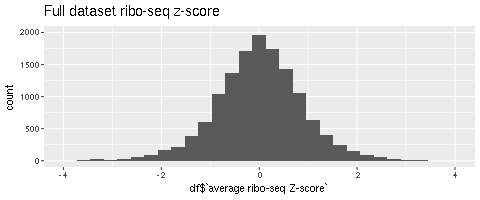

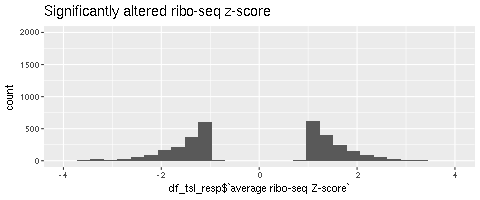

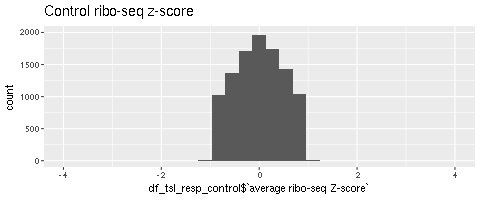

In [3]:
%%R -h 200
# Filters out statistically significant tsl change genes
df_tsl_resp <- filter(df, `exceeds 10% FDR threshold` == "True")
df_tsl_resp$`Gene symbol` <- toupper(df_tsl_resp$`Gene symbol`)
# df_tsl_resp_up corresponds to the upregulated set
df_tsl_resp_up <- filter(df_tsl_resp, `average ribo-seq Z-score` > 0)
# df_tsl_resp_down corresponds to the downregulated set
df_tsl_resp_down <- filter(df_tsl_resp, `average ribo-seq Z-score` < 0)

# df_tsl_resp_control corresponds to the control set
df_tsl_resp_control <- filter(df, `exceeds 10% FDR threshold` == "False")
df_tsl_resp_control$`Gene symbol` <- toupper(df_tsl_resp_control$`Gene symbol`)

# Plots each dataset's average ribo-seq Z-score
print(qplot(df$`average ribo-seq Z-score`, 
            main="Full dataset ribo-seq z-score") + xlim(-4, 4) + ylim(0, 2000))
print(qplot(df_tsl_resp$`average ribo-seq Z-score`, 
            main="Significantly altered ribo-seq z-score") + xlim(-4, 4)+ ylim(0, 2000))
print(qplot(df_tsl_resp_control$`average ribo-seq Z-score`,
            main="Control ribo-seq z-score") + xlim(-4, 4)+ ylim(0, 2000))

## Writing Gene names to file

Next, we want to write the gene symbols associated with the genes in each of the three sets to file. 
We are going to use these gene symbols to filter the [Ensembl CDS dataset for *H. sapiens*](https://useast.ensembl.org/info/data/ftp/index.html), to get the associated coding sequence (ie mRNA sequence) for each gene, delineated by D.E. Andreev translation status (upreg, downreg, control).

In [4]:
%%R

# Writes resulting filtered gene symbols to file
write_csv(select(df_tsl_resp_up, `Gene symbol`) ,"./data/hsapiens/andreev_genes_up.csv")
write_csv(select(df_tsl_resp_down, `Gene symbol`) ,"./data/hsapiens/andreev_genes_down.csv")
write_csv(select(df_tsl_resp_control, `Gene symbol`) ,"./data/hsapiens/andreev_genes_control.csv")

## Getting CDS Sequences for D.E. Andreev Genes

Here, we define a Python program that takes the gene symbols we just wrote to file, and grabs all of the CDS (ie mRNA sequences) associated with each respective gene sets from the Ensembl CDS set. Note that, as the Ensembl set is quite large, there will be (on average) more than one CDS available per gene.

In [14]:
def read_fasta_and_filter(fasta_file, gene_file, mode="up"):
    with open(fasta_file) as f:
        # Opens the gene_file, corresponding to all genes that have widespread
        # alterations in mRNA translation within 60 minutes
        gene_symbols = read_gene_file(gene_file)

        fasta_df = []
        header = ""
        sequence = ""
        hit_counter = 0
        gene_symbol = ""

        # This variable concatenates the dataset of sequences, obtaining
        # background nucleotide frequencies for the human genome
        total_sequence_aggregator = ""

        # Initializes dict containing counts for each gene_symbol
        gene_symbol_counter = {}
        for gene in gene_symbols:
            gene_symbol_counter[gene] = 0

        # Reads in all of lines in FASTA file
        while True:
            line = f.readline()
            # End condition
            if not line:
                # if we're exiting the loop, there should be an unwritten
                # header, sequence pair left to write
                if header and sequence and gene_symbol.strip() in gene_symbols:
                    # We write the unwritten pair, if it should be written
                    fasta_df.append([header, sequence, gene_symbol])
                    hit_counter += 1
                    gene_symbol_counter[gene_symbol] += 1

                if sequence[:3] is "ATG" and sequence[-3:] in ["TAA","TAG","TGA"]:
                    total_sequence_aggregator += sequence
                # Then we exit the loop
                break

            # Encountering a new FASTA header
            if line[0] == ">":
                # If appropriate, we write the header and sequence to our list
                if header and sequence and gene_symbol.strip() in gene_symbols:
                    fasta_df.append([header, sequence, gene_symbol])
                    hit_counter += 1
                    gene_symbol_counter[gene_symbol] += 1

                # Aggregates all valid genes to total_sequence_aggregator
                start = sequence[:3]
                end   = sequence[-3:]
                if start == "ATG" and (end in ["TAA","TAG","TGA"]):
                    total_sequence_aggregator += sequence

                # We read in the new header
                header = line[1:]
                # Parsing the gene_symbol using RegEx
                gene_symbol = re.search("(?<=gene_symbol:)[^\s]*", header).group(0)
                # Initialize new empty sequence
                sequence = ""
            # Adding to sequence
            else:
                sequence += re.sub("\s", "", line)

        avg_hits = sum(gene_symbol_counter.values())/len(gene_symbol_counter.values())
        avg_hits = round(avg_hits, 2)
        print("Number of hits is {}, average hits per gene is {}".format(round(hit_counter, 2), avg_hits))
        
        with open("./data/hsapiens/runs/hits_{}.csv".format(mode), "w") as outfile:
           writer = csv.writer(outfile)
           writer.writerow(["num_hits"])
           writer.writerows(map(lambda x : [str(x)], gene_symbol_counter.values()))

        return [fasta_df, total_sequence_aggregator]

def read_gene_file(gene_file):
    with open(gene_file) as f:
        gene_names = []
        f.readline() # throws away header line
        while True:
            line = f.readline()
            if line:
                gene_names.append(line.strip())
            else:
                break

        return gene_names

def write_fasta_file(fasta_df, filename):
     with open("./data/hsapiens/{}".format(filename), "w") as outfile:
        writer = csv.writer(outfile)
        for fasta in fasta_df:
            writer.writerow(fasta)
     return
    

def calculate_nucleotide_freqs(total_seq):
    count_dict = {}
    for letter in total_seq:
        if letter not in count_dict:
            count_dict[letter] = 0
        count_dict[letter] += 1
    if "N" in count_dict:
        del count_dict["N"]

    total = count_dict["A"] + count_dict["T"] + count_dict["C"] + count_dict["G"]
    freq_dict = {k: v / float(total) for k, v in count_dict.items()}
    for nucleo in freq_dict:
        print("{} has frequency {}".format(nucleo, round(freq_dict[nucleo], 5)))
    return freq_dict

Now, we run this program on each of our three sets of genes.

As a side effect, we also calculate the nucleotide frequencies associated with the Ensembl CDS dataset.

In [15]:
# For the upregulated set of D.E. Andreev genes
print(">>Upregulated genes")
fasta_file = "./data/hsapiens/Homo_sapiens.GRCh38.cds.all.fa"
gene_file  = "./data/hsapiens/andreev_genes_up.csv"
[fasta_df, total_seq] = read_fasta_and_filter(fasta_file, gene_file, "up")
write_fasta_file(fasta_df, "fasta_andreev_genes_up.csv")

# For the downregulated set of D.E. Andreev genes
print(">>Downregulated genes")
fasta_file = "./data/hsapiens/Homo_sapiens.GRCh38.cds.all.fa"
gene_file  = "./data/hsapiens/andreev_genes_down.csv"
[fasta_df, total_seq] = read_fasta_and_filter(fasta_file, gene_file, "down")
write_fasta_file(fasta_df, "fasta_andreev_genes_down.csv")

# For the control set of D.E. Andreev genes
print(">>Control genes")
fasta_file = "./data/hsapiens/Homo_sapiens.GRCh38.cds.all.fa"
gene_file  = "./data/hsapiens/andreev_genes_control.csv"
[fasta_df, total_seq] = read_fasta_and_filter(fasta_file, gene_file, "control")
write_fasta_file(fasta_df, "fasta_andreev_genes_control.csv")

# Calculates background nucleotide frequency among D.E. Andreev H. sapiens genes
print(" --- Calculating background nucleotide frequencies for all genes ---")
nucleo_freqs = calculate_nucleotide_freqs(total_seq)

>>Upregulated genes
Number of hits is 6896, average hits per gene is 4.22
>>Downregulated genes
Number of hits is 8433, average hits per gene is 5.27
>>Control genes
Number of hits is 54061, average hits per gene is 4.26
 --- Calculating background nucleotide frequencies for all genes ---
A has frequency 0.25961
T has frequency 0.21846
G has frequency 0.26273
C has frequency 0.2592


## Plotting the number of gene repetitions in Ensembl CDS Data

As we see above, the number of CDS repetitions per gene doesn't seem to have a pattern at first glance. Let's confirm this by graphing the distribution of hits using R.

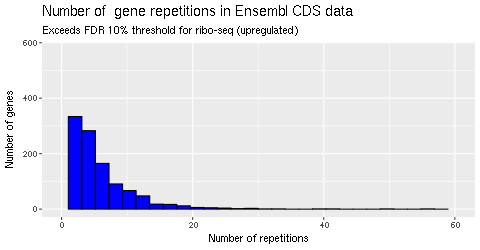

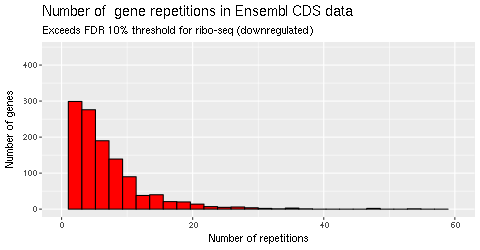

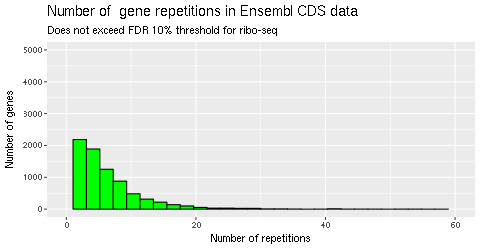

In [7]:
%%R -h 250

df_ensembl_hits_up <- read_csv("./data/hsapiens/runs/hits_up.csv")
df_ensembl_hits_down <- read_csv("./data/hsapiens/runs/hits_down.csv")
df_ensembl_hits_control <- read_csv("./data/hsapiens/runs/hits_control.csv")

print(ggplot(df_ensembl_hits_up, aes(x=df_ensembl_hits_up)) + geom_histogram(bins = 30, color="black", fill="blue") +
  labs(title="Number of  gene repetitions in Ensembl CDS data",
         subtitle="Exceeds FDR 10% threshold for ribo-seq (upregulated)",
         x = "Number of repetitions",
         y = "Number of genes") + xlim(0, 60))

print(ggplot(df_ensembl_hits_down, aes(x=df_ensembl_hits_down)) + geom_histogram(bins = 30, color="black", fill="red") +
  labs(title="Number of  gene repetitions in Ensembl CDS data",
         subtitle="Exceeds FDR 10% threshold for ribo-seq (downregulated)",
         x = "Number of repetitions",
         y = "Number of genes") + xlim(0, 60))

print(ggplot(df_ensembl_hits_control, aes(x=df_ensembl_hits_control)) + geom_histogram(bins = 30, color="black", fill="green") +
  labs(title="Number of  gene repetitions in Ensembl CDS data",
         subtitle="Does not exceed FDR 10% threshold for ribo-seq",
         x = "Number of repetitions",
         y = "Number of genes") + xlim(0, 60))

As you can see from the plots above, the repetition distributions look approximately equal. There doesn't seem to be any pattern discerning each of the three D.E. Andreev sets.

## Further filtering the FASTA candidate genes

We want to analyze the nucleotide periodicity of the subset of our three D.E. Andreev sets containing valid, canonical coding sequences. We define valid, canonical coding sequences as those starting with an ATG, and end with a valid stop codon 

(**Should I add the stringency that they be in frame? Should alter this code!**).

Of all of the valid, canonical CDS sequences, we randomly pick one such sequence per gene symbol, yielding a dataset which has one representative CDS sequence per gene symbol. To avoid any noise in the data, we repeat this sampling procedure five times, yielding five separate samplings of the three D.E. Andreev tsl state representative CDS datasets (upregulated, downregulated, control).


In [8]:
%%R
# Helper function for taking the right substring in R (why isn't this built in...)
substrRight <- function(x, n){
  substr(x, nchar(x)-n+1, nchar(x))
}

# Reads in the dataset generated by read_fasta.py
andreev_fasta_df_up <- read_csv("./data/hsapiens/fasta_andreev_genes_up.csv", col_names=F)
andreev_fasta_df_down <- read_csv("./data/hsapiens/fasta_andreev_genes_down.csv", col_names=F)
andreev_fasta_df_control <- read_csv("./data/hsapiens/fasta_andreev_genes_control.csv", col_names=F)

filterGenes <- function(andreev_fasta_df) {
  andreev_df <- andreev_fasta_df %>%
    # Ensures that the sequence starts with ATG and ends with a valid stop codon
    filter(substr(X2, 1, 3) == "ATG") %>%
    filter(substrRight(X2, 3) %in% c("TAG", "TAA", "TGA")) %>%
    filter(nchar(X2) > 35) %>%
    # Randomly samples one member of each represented gene
    group_by(X3) %>%
    sample_n(size = 1) %>%
    mutate(frame=substr(X2, 1, 35))
  colnames(andreev_df) <- c("FASTAHeader", "Sequence", "geneSymbol", "Frame")
  
  return(andreev_df)
}

set.seed(1)
andreev_df_up <- c()
andreev_df_down <- c()
andreev_df_control <- c()

for (i in 1:5) {
  andreev_df_up[[i]] <- filterGenes(andreev_fasta_df_up)
  andreev_df_down[[i]] <- filterGenes(andreev_fasta_df_down)
  andreev_df_control[[i]] <- filterGenes(andreev_fasta_df_control)
}

## Writing the fasta files

Here, we write the FASTA files associated with the upregulated and downregulated 
D.E. Andreev genes (for each of the five samplings), ready for use with the IGS Information Theoretic Alignment Analysis Tool.

We input the background frequencies obtained using the Python program which obtained the Ensembl CDS genes for each of the three D.E. Andreev tsl sets. Recall them:

In [9]:
for nucleo in nucleo_freqs:
    print("{} has frequency {}".format(nucleo, round(nucleo_freqs[nucleo], 5)))

A has frequency 0.25961
T has frequency 0.21846
G has frequency 0.26273
C has frequency 0.2592


Here, we're outputting our three sets of filtered FASTA dataframes, 
for 5 samplings, to disk, to be used with the Information Theory IGS web tool.

(**Note:** We take a random sample of 5000 of the control genes, because the number of genes allowed to be input in the Information Theoretic Analysis on IGS server is less than the total number of genes in the D.E. Andreev control set)

In [10]:
%%R
for (i in 1:5) {
  andreev_df_up[[i]]$FASTAHeader <- trimws(paste(">", andreev_df_up[[i]]$FASTAHeader, sep=""))
  andreev_df_down[[i]]$FASTAHeader <- trimws(paste(">", andreev_df_down[[i]]$FASTAHeader, sep=""))
  andreev_df_control[[i]]$FASTAHeader <- trimws(paste(">", andreev_df_control[[i]]$FASTAHeader, sep=""))
  
  randomRows = function(df,n){
     return(df[sample(nrow(df),n),])
  }
  
  andreev_df_control[[i]] <- randomRows(andreev_df_control[[i]], 5000)
  
  fasta_lines_up = c(rbind(andreev_df_up[[i]]$FASTAHeader, andreev_df_up[[i]]$Frame))
  fasta_lines_down = c(rbind(andreev_df_down[[i]]$FASTAHeader, andreev_df_down[[i]]$Frame))
  fasta_lines_control = c(rbind(andreev_df_control[[i]]$FASTAHeader, andreev_df_control[[i]]$Frame))
  
  up_path <- paste("./data/hsapiens/gene_samplings_fasta/", i, 
                   "/andreev_genes_up_", i, ".fa", sep="")
  down_path <- paste("./data/hsapiens/gene_samplings_fasta/", i, 
                   "/andreev_genes_down_", i, ".fa", sep="" )
  control_path <- paste("./data/hsapiens/gene_samplings_fasta/", i, 
                   "/andreev_genes_control_", i, ".fa", sep="" )
  
  write_lines(fasta_lines_up, path=up_path)
  write_lines(fasta_lines_down, path=down_path)
  write_lines(fasta_lines_control, path=control_path)
}

## Inputting into IGS Information Theory Tool

I did this manually. I could have done this via an automated process, and perhaps should develop a Selenium workflow to do this in future. The tool itself is found [here](http://igs.wesleyan.edu/), under 'Databases & Tools'.

## Reading in Results of Information Theory Analysis

Now, we're taking the csv representation of the results of said analysis, and 
producing three sets of data (corresponding to the upregulated genes, 
downregulated genes and control) for each of the five samplings.

In [11]:
%%R
infotheory_up <- c()
infotheory_down <- c()
infotheory_control <- c()

for (i in 1:5) {
  infotheory_up[[i]] <- read_csv(
      paste("./data/hsapiens/gene_samplings_fasta/", i, 
            "/infotheory_up_", i, ".csv", sep="")) %>%
      filter(pos > 3)
  infotheory_down[[i]] <- read_csv(
      paste("./data/hsapiens/gene_samplings_fasta/", i, 
            "/infotheory_down_", i, ".csv", sep="")) %>%
    filter(pos > 3)
  infotheory_control[[i]] <- read_csv(
      paste("./data/hsapiens/gene_samplings_fasta/", i, 
            "/infotheory_control_", i, ".csv", sep="")) %>%
    filter(pos > 3)
}

Now, let's graph them all juxtaposed to each other, showcasing that the patterns
shown seem conserved across the board (to ensure the data is free of noise)

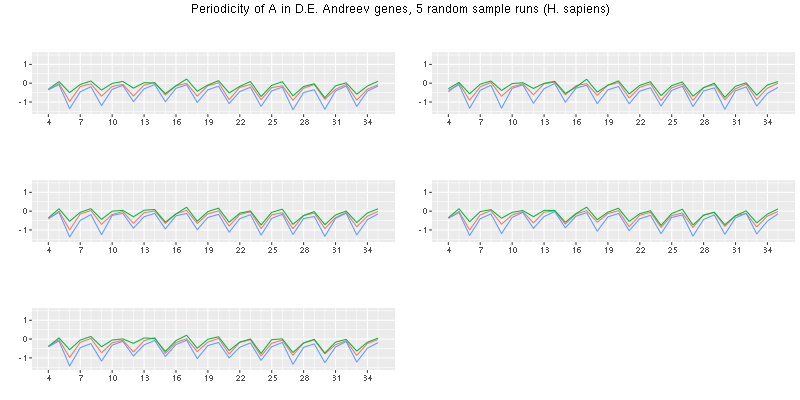

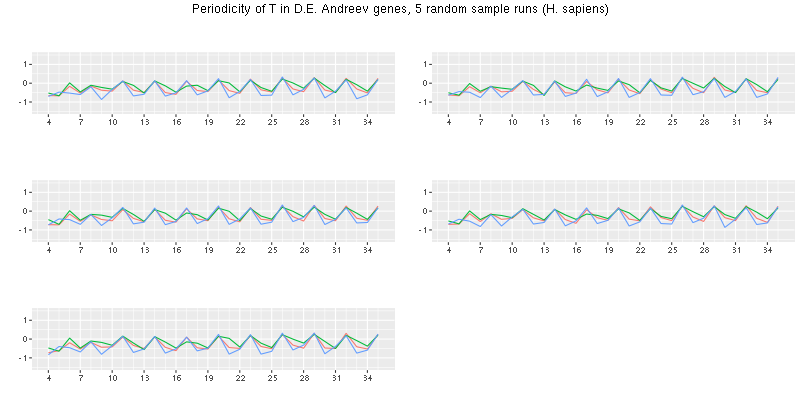

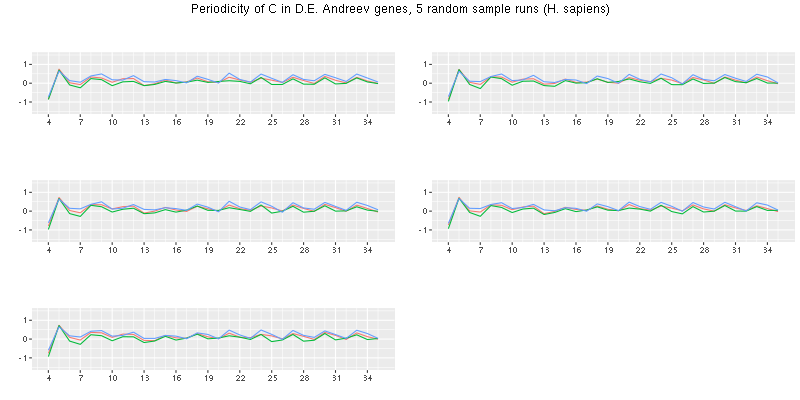

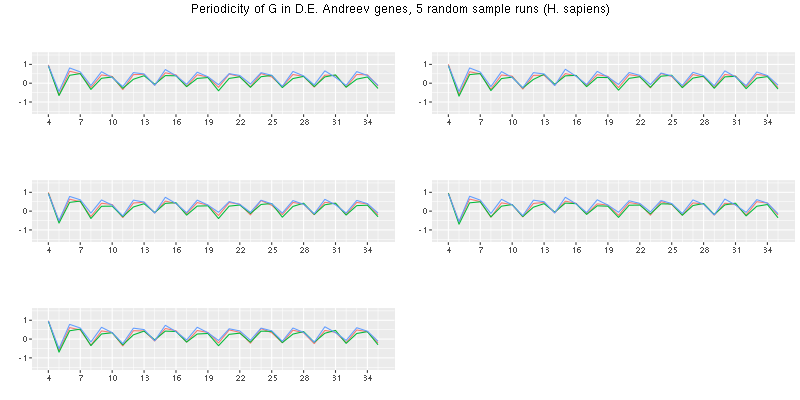

In [181]:
%%R -w 800 -h 400
getWeightsOfNucleotide <- function(graph_data_up, graph_data_down, graph_data_control, nt) {
  graph_data_combined_up <- graph_data_up %>%
    filter(nucleotide ==nt) %>%
    mutate(label="up")
  
  graph_data_combined_down <- graph_data_down %>%
    filter(nucleotide ==nt) %>%
    mutate(label="down")
  
  graph_data_combined_control <- graph_data_control %>%
    filter(nucleotide ==nt) %>%
    mutate(label="control")
  
  graph_data_combined <- rbind(graph_data_combined_up, 
                               graph_data_combined_down,
                               graph_data_combined_control)
  
  return(graph_data_combined)
  
}

plotResult <- function(graph_data_combined, nt, postfix) {
  ggplot(graph_data_combined, aes(x=pos, y=relativeWeight, color=label)) +
           geom_line() + scale_x_continuous(breaks = seq(5, 35, 3)) + labs(
      x= "Position in CDS",
      y= "Relative Weight (by InfoTheory)",
      title=paste(nt, "Frequency along CDS (H. sapiens)"),
      subtitle=paste("D.E. Andreev filtered genes (up + down regulated)", postfix)
    ) + ylim(-1.5, 1.5)
}
 
library(tidyr)
library(plyr)

plotInfoTheoryResults <- function(infotheory_up, infotheory_down, infotheory_control, i) {
  
  graph_data_up <- infotheory_up %>%
    select(pos, relWeightA, relWeightT, relWeightG, relWeightC) %>%
    gather(nucleotide, relativeWeight, -pos)
  graph_data_up$nucleotide <- mapvalues(graph_data_up$nucleotide,
            from=c("relWeightA","relWeightC","relWeightT", "relWeightG"), 
            to=c("A","C","T","G"))
  
  graph_data_down <- infotheory_down %>%
    select(pos, relWeightA, relWeightT, relWeightG, relWeightC) %>%
    gather(nucleotide, relativeWeight, -pos)
  graph_data_down$nucleotide <- mapvalues(graph_data_down$nucleotide,
            from=c("relWeightA","relWeightC","relWeightT", "relWeightG"), 
            to=c("A","C","T","G"))
  
  graph_data_control <- infotheory_control %>%
    select(pos, relWeightA, relWeightT, relWeightG, relWeightC) %>%
    gather(nucleotide, relativeWeight, -pos)
  graph_data_control$nucleotide <- mapvalues(graph_data_control$nucleotide,
            from=c("relWeightA","relWeightC","relWeightT", "relWeightG"), 
            to=c("A","C","T","G"))
  
  a_data_combined <- getWeightsOfNucleotide(graph_data_up, graph_data_down, 
                                                graph_data_control, "A")
  t_data_combined <- getWeightsOfNucleotide(graph_data_up, graph_data_down, 
                                                graph_data_control, "T")
  c_data_combined <- getWeightsOfNucleotide(graph_data_up, graph_data_down, 
                                                graph_data_control, "C")
  g_data_combined <- getWeightsOfNucleotide(graph_data_up, graph_data_down, 
                                                graph_data_control, "G")
  
  a <- plotResult(a_data_combined, "A", i) +
    scale_x_continuous(breaks=seq(1,35,3), minor_breaks=seq(1,35))
  t <- plotResult(t_data_combined, "T", i) +
    scale_x_continuous(breaks=seq(1,35,3), minor_breaks=seq(1,35))
  c <- plotResult(c_data_combined, "C", i) +
    scale_x_continuous(breaks=seq(1,35,3), minor_breaks=seq(1,35))
  g <- plotResult(g_data_combined, "G", i) +
    scale_x_continuous(breaks=seq(1,35,3), minor_breaks=seq(1,35))
  
  return(list(a,t,c,g))
}

res <- list()
for (i in 1:5) {
  res[i] <- list(plotInfoTheoryResults(infotheory_up[[i]], infotheory_down[[i]], infotheory_control[[i]], paste("Run:", i)))
}

library(gridExtra)
nts <- c("A","T","C","G")
for (j in 1:4) {
  grid.arrange(res[[1]][[j]] + labs(x="", y="", title="", subtitle="") + theme(legend.position="none"),
               res[[2]][[j]] + labs(x="", y="", title="", subtitle="") + theme(legend.position="none"), 
               res[[3]][[j]] + labs(x="", y="", title="", subtitle="") + theme(legend.position="none"), 
               res[[4]][[j]] + labs(x="", y="", title="", subtitle="") + theme(legend.position="none"), 
               res[[5]][[j]] + labs(x="", y="", title="", subtitle="") + theme(legend.position="none"), 
               ncol=2, nrow=3, top=paste("Periodicity of",nts[j],"in D.E. Andreev genes, 5 random sample runs (H. sapiens)"))
}

It's obvious now that the patterns observed are conserved across the different runs. So, let's graph the aggregation of the runs, to show general patterns across the 5 samplings, absent of noise.

[[1]]

[[2]]

[[3]]

[[4]]



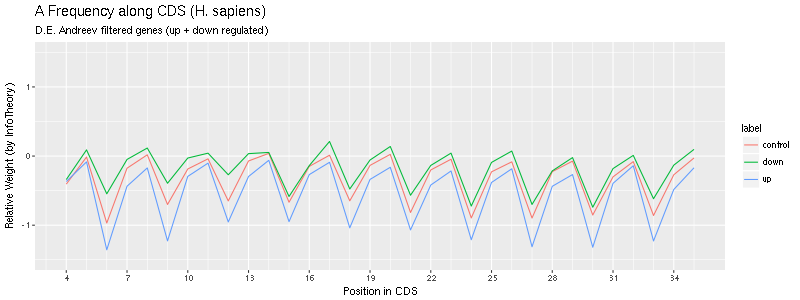

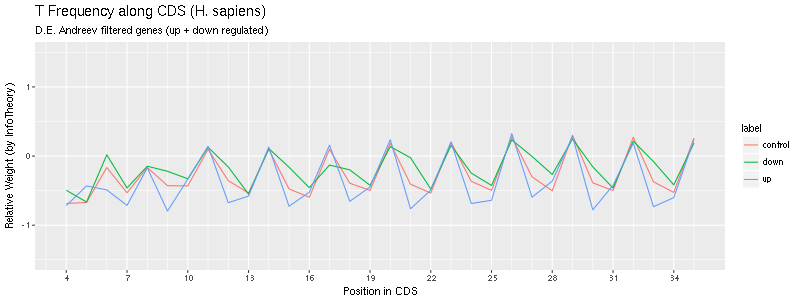

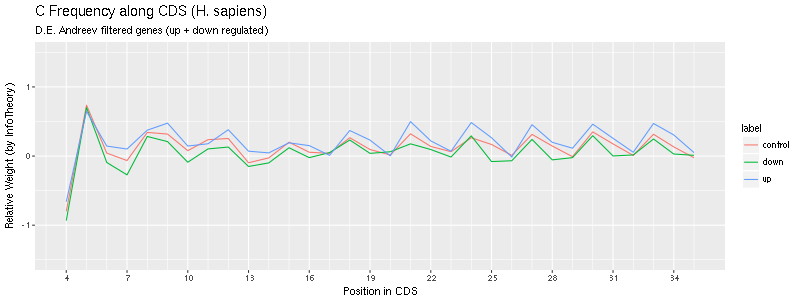

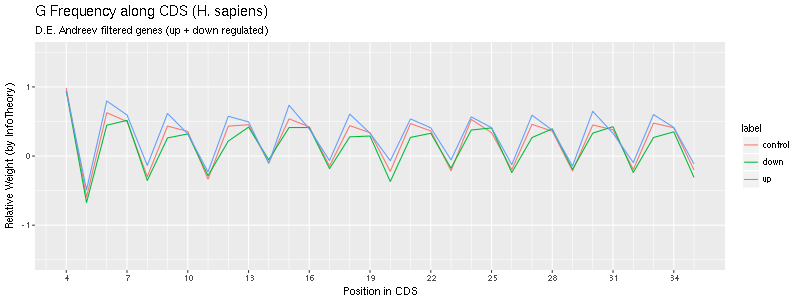

In [182]:
%%R -h 300 -w 800
info_up_agg = data.frame(aaply(laply(infotheory_up, as.matrix), c(2, 3), mean))
info_down_agg = data.frame(aaply(laply(infotheory_down, as.matrix), c(2, 3), mean))
info_control_agg = data.frame(aaply(laply(infotheory_control, as.matrix), c(2, 3), mean))

plotInfoTheoryResults(info_up_agg, info_down_agg, info_control_agg, "")

## Sequence Walker Analysis

Having seen significantly different nucleotide frequencies between the different D.E. Andreev sets, let's try to see what the sequence walker code we've been working with for so long will reveal. 

As we've established every sampling of the Ensembl CDS genes (for each D.E. Andreev gene set) is approximately equivalent, let's generate the list of sequences associated with each set in R, and export those sequence sets to Python.

In [26]:
%%R -o andreev_up_sequences -o andreev_down_sequences -o andreev_control_sequences
# Note: The -o flag exports an R object to Python (quite neat!!)
andreev_up_sequences      <- andreev_df_up[[1]]$Sequence
andreev_down_sequences    <- andreev_df_down[[1]]$Sequence
andreev_control_sequences <- andreev_df_control[[1]]$Sequence

Recall the sequence walker code, shown below. 

(**Note:** This code was written by Prof. Weir, and modified by me to remove unnecessary elements for this notebook, as well as to port to Python 3)

In [48]:
'''
Computes the number of hydrogen bonds between
4-nt window of mRNA and 527 to 530 of rRNA 530 loop
(Note: In this case we're only doing the 2-mer model for C527, G528)
'''
def hbonds530(dna4):

    p = {}
    #p[0]={'A':0,'C':3,'G':0,'T':2}
    #p[1]={'A':0,'C':3,'G':0,'T':2}
    p[2]={'A':0,'C':0,'G':3,'T':0}
    p[3]={'A':0,'C':3,'G':0,'T':2}
    #p[4]={'A':0,'C':0,'G':3,'T':0}
    
    score = 0
    for i in range(2,4):
        score += p[i][dna4[i]]

    return score

# scans a DNA with 4-nt window according to hbonds530
def scan(dna):
    scores= []
    for i in range(len(dna)-3):
        scores += [hbonds530(dna[i:i+4])]
    return scores

# screens file with one DNA per line
def screendnas(dna_seq_list):
    
    scoreset = []
    for dna in dna_seq_list:
        scoreset += [scan(dna.strip()[:50])]
            
    n = len(scoreset)
    d = len(scoreset[0])
    
    averages = []
    for i in range(d):
        averages += [0]
    for i in range(d):
        for scores in scoreset:
            averages[i] += scores[i]
    results = []
    for a in range(d):
        results.append(averages[a]*1.0/n)
    return results

Let's ensure that all of the sequences have at least length 50, and plug the filtered sequence lists into the sequence walker code ...

In [106]:
# Filters out sequences with length less than 50
andreev_f_up_sequences = list(filter(lambda x : len(x) >= 50, 
                                     andreev_up_sequences))
andreev_f_down_sequences = list(filter(lambda x : len(x) >= 50, 
                                       andreev_down_sequences))
andreev_f_control_sequences = list(filter(lambda x : len(x) >= 50, 
                                          andreev_control_sequences))

# Runs sequence walker on all filtered sequence lists
andreevupwalker      = screendnas(andreev_f_up_sequences)
andreevdownwalker    = screendnas(andreev_f_down_sequences)
andreevcontrolwalker = screendnas(andreev_f_control_sequences)
walkerseqs = [andreevupwalker, andreevdownwalker, andreevcontrolwalker]

... and let's graph them in R using `ggplot` ...

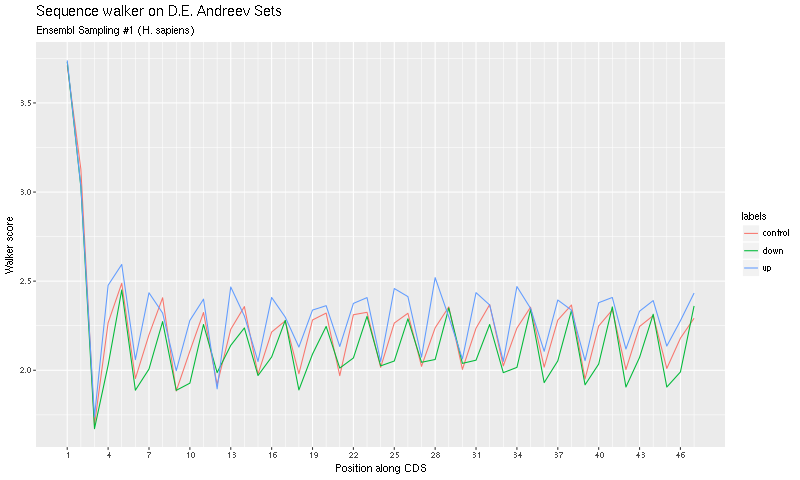

In [175]:
%%R -i walker_seqs -w 800

andreev_up_walker <- as.numeric(unlist(walker_seqs[[1]]))
andreev_down_walker <- as.numeric(unlist(walker_seqs[[2]]))
andreev_control_walker <- as.numeric(unlist(walker_seqs[[3]]))

total_walker <- c(andreev_up_walker, andreev_down_walker, andreev_control_walker)
position  <- seq(1, 47)
total_positions <- rep(position, 3)
labels <- c(rep("up", 47), rep("down", 47), rep("control", 47))

df <- data.frame(total_positions, as.numeric(as.character(total_walker)), labels)
ggplot(df, aes(x=total_positions, y=total_walker, color=labels)) + geom_line() +
    labs(title="Sequence walker on D.E. Andreev Sets", subtitle="Ensembl Sampling #1 (H. sapiens)",
         x="Position along CDS", y="Walker score") +
    scale_x_continuous(breaks=seq(1,47,3), minor_breaks=seq(1,47))